# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the seven-qubit Steane code

In [1]:
from typing import List, Dict, Sequence
import itertools
import functools
import numpy as np
import cirq
import qiskit
from qiskit.circuit.library import Barrier
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt

from mitiq import PauliString

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [3]:
n = 7                                   # Number of physical qubits
nshots = 20_000                         # Number of samples/shots
depths = np.arange(0, 240 + 1, 20)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.

In [4]:
# Computer and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend("ibm_brisbane")
sampler = Sampler(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    1 : [103],
    7 : [103, 104, 105, 111, 121, 122, 123],
}

# Good qubits on Fez Jan 20.
# layout = {
#     1 : [2],
#     7 : [2, 3, 4, 16, 22, 23, 24],
# }

## Helper functions

In [5]:
# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

# Prepares logical |0> state on Steane Code
def encode_steane(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on(qreg[0]))
    circuit.append(cirq.H.on(qreg[4]))
    circuit.append(cirq.H.on(qreg[6]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[5]))

    circuit.append(cirq.CNOT.on(qreg[6], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[6], qreg[5]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[2]))
    
    circuit.append(cirq.CNOT.on(qreg[0], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[3], qreg[2]))

    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [6]:
qreg = cirq.LineQubit.range(k)

to_run_raw = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )
    to_run_raw.append(compiled_raw)

In [7]:
to_run_raw[-1].draw(fold=-1, idle_wires=False)

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░ ┌─┐
q_0 -> 103 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤M├
           └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░ └╥┘
measure: 1/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [8]:
job_raw = sampler.run(
    to_run_raw,
    shots=nshots,
)

In [17]:
all_counts_raw = [result.data.measure.get_counts() for result in job_raw.result()]
observable = PauliString("Z")._pauli
evals_raw = [compute_expectation(observable, counts_raw) for counts_raw in all_counts_raw]

In [18]:
evals_raw

[0.9755,
 0.96,
 0.8514,
 0.6327,
 0.3426,
 0.0114,
 -0.3312,
 -0.6071,
 -0.8061,
 -0.8892,
 -0.8434,
 -0.6806,
 -0.4375]

# Run encoded experiment

In [9]:
generator_strs = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]
observable = PauliString("Z" * n)._pauli
qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)
# print(measurement_circuit)


In [10]:
encoding = encode_steane(qreg)
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

measurement = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit.to_qasm())

circ_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement)
circ_full.measure_active()

compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

compiled.draw(fold=-1, idle_wires=False)
# compiled.count_ops()

global phase: 3π/2
           ┌──────────┐┌────┐ ┌─────────────┐ ┌────┐┌──────────┐┌──────┐  ┌──────────┐       ┌────┐     ┌──────────────┐┌────┐┌─────────┐                                                                                                                                                                                                                                   ┌──────┐ ┌──────────┐   ┌────┐   ┌──────────────┐                                                                                                                                                                                                           encoding  measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐ ┌────────┐   ┌────┐                                                                                    ┌──────┐  ┌──────────┐   ┌────┐  ┌─────────┐ ┌──────┐┌────┐┌────────────┐┌────┐┌─────────┐                                                                                                                                                                                                                                                                              ┌──────┐   ┌──────────┐   ┌────┐   ┌─────────────┐   ┌────┐   ┌──────────┐                                                                                                                                                                    ┌──────┐  ┌──────────┐   ┌────┐   ┌──────────────┐     ┌────┐    ┌──────────┐                                                                                                                                                                                                                                                  ░ ┌─┐                  
q_0 -> 103 ┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-1.3983) ├─┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├───────┤ √X ├─────┤ Rz(-0.85034) ├┤ √X ├┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.67786) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├─┤ Rz(-π) ├───┤ √X ├────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├───┤ √X ├──┤ Rz(π/2) ├─┤1     ├┤ √X ├┤ Rz(2.5763) ├┤ √X ├┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-2.2656) ├───┤ √X ├───┤ Rz(-π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.71981) ├─────┤ √X ├────┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├──────────────────
           ├─────────┬┘├────┤ ├─────────────┴┐└────┘└──────────┘│  Ecr │  └──┬───┬───┘  ┌────┴────┴───┐ └──────────────┘└────┘└─────────┘                                                                                        ┌──────┐  ┌─────────┐    ┌────┐                 ┌──────┐   ┌──────────┐                        ┌──────┐ ┌────────┐   ┌────┐   ┌─────────┐  │  Ecr │ └──┬───┬───┘  ┌┴────┴┐  └─

In [11]:
to_run = []
for depth in depths:
    temp = compiled.copy_empty_like()
    for instruction in compiled.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(temp):
                    temp.x(q)
        temp.append(
            instruction, instruction.qubits
        )
    to_run.append(temp)

In [12]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 3π/2
           ┌──────────┐┌────┐ ┌─────────────┐ ┌────┐┌──────────┐┌──────┐  ┌──────────┐       ┌────┐     ┌──────────────┐┌────┐┌─────────┐                                                                                                                                                                                                                                   ┌──────┐ ┌──────────┐   ┌────┐   ┌──────────────┐                                                                                                                                                                                                           encoding ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐ ┌────────┐   ┌────┐                                                                                    ┌──────┐  ┌──────────┐   ┌────┐  ┌─────────┐ ┌──────┐┌────┐┌────────────┐┌────┐┌─────────┐                                                                                                                                                                                                                                                                              ┌──────┐   ┌──────────┐   ┌────┐   ┌─────────────┐   ┌────┐   ┌──────────┐                                                                                                                                                                    ┌──────┐  ┌──────────┐   ┌────┐   ┌──────────────┐     ┌────┐    ┌──────────┐                                                                                                                                                                                                                                                  ░ ┌─┐                  
q_0 -> 103 ┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-1.3983) ├─┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├───────┤ √X ├─────┤ Rz(-0.85034) ├┤ √X ├┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.67786) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├

In [13]:
to_run[-1].count_ops()

OrderedDict([('x', 1690),
             ('rz', 234),
             ('sx', 131),
             ('ecr', 65),
             ('measure', 7),
             ('barrier', 3)])

In [14]:
job = sampler.run(
    to_run,
    shots=nshots,
)

In [19]:
all_counts = [result.data.measure.get_counts() for result in job.result()]
evals = [compute_expectation(observable, counts) for counts in all_counts]

## With DD

In [15]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [16]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)

In [20]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
evals_dd = [compute_expectation(observable, counts) for counts in all_counts_dd]

## Plot data

In [21]:
save_key = f"memory_steane_zero_state_z_{computer.name}_{time_key}_job_raw_id_{job_raw.job_id()}_job_encoded_id_{job.job_id()}_job_encoded_dd_id_{job_dd.job_id()}"

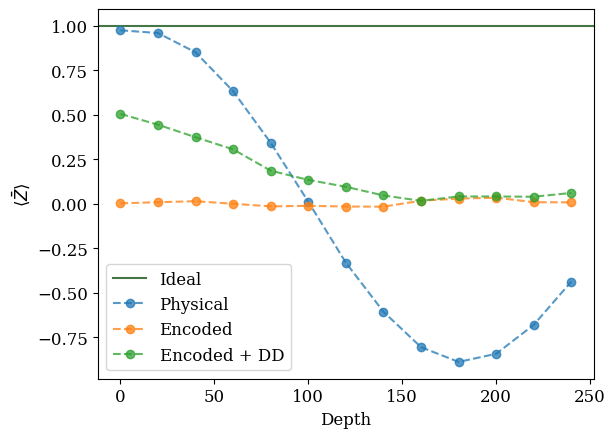

In [22]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75

plt.axhline(1.0, label="Ideal", alpha=alpha, color="xkcd:darkgreen")
plt.plot(depths, evals_raw, "--o", alpha=alpha, label="Physical")
plt.plot(depths, evals, "--o", alpha=alpha, label="Encoded")
plt.plot(depths, evals_dd, "--o", alpha=alpha, label="Encoded + DD")

plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")

plt.legend();
plt.savefig(save_key + ".pdf")